[![Fixel Algorithms](https://i.imgur.com/AqKHVZ0.png)](https://fixelalgorithms.gitlab.io/)

# Least Squares with ${L}^{1}$ / ${L}^{2}$ Regularization

> Notebook by:
> - Royi Avital RoyiAvital@fixelalgorithms.com

## Revision History

| Version | Date       | User        |Content / Changes                                                   |
|---------|------------|-------------|--------------------------------------------------------------------|
| 1.0.000 | 24/03/2024 | Royi Avital | First version                                                      |

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/AIProgram/2024_02/0047RegressorL1L2Regularization.ipynb)

In [3]:
# Import Packages

# General Tools
import numpy as np
import scipy as sp
import pandas as pd

# Machine Learning
from sklearn.linear_model import Lasso, Ridge
from sklearn.linear_model import lars_path, lasso_path
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

# Miscellaneous
import math
import os
from platform import python_version
import random
import timeit

# Typing
from typing import Callable, Dict, List, Optional, Set, Tuple, Union

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Jupyter
from IPython import get_ipython
from IPython.display import Image
from IPython.display import display
from ipywidgets import Dropdown, FloatSlider, interact, IntSlider, Layout, SelectionSlider
from ipywidgets import interact

## Notations

* <font color='red'>(**?**)</font> Question to answer interactively.
* <font color='blue'>(**!**)</font> Simple task to add code for the notebook.
* <font color='green'>(**@**)</font> Optional / Extra self practice.
* <font color='brown'>(**#**)</font> Note / Useful resource / Food for thought.

Code Notations:

```python
someVar    = 2; #<! Notation for a variable
vVector    = np.random.rand(4) #<! Notation for 1D array
mMatrix    = np.random.rand(4, 3) #<! Notation for 2D array
tTensor    = np.random.rand(4, 3, 2, 3) #<! Notation for nD array (Tensor)
tuTuple    = (1, 2, 3) #<! Notation for a tuple
lList      = [1, 2, 3] #<! Notation for a list
dDict      = {1: 3, 2: 2, 3: 1} #<! Notation for a dictionary
oObj       = MyClass() #<! Notation for an object
dfData     = pd.DataFrame() #<! Notation for a data frame
dsData     = pd.Series() #<! Notation for a series
hObj       = plt.Axes() #<! Notation for an object / handler / function handler
```

### Code Exercise

 - Single line fill

 ```python
 vallToFill = ???
 ```

 - Multi Line to Fill (At least one)

 ```python
 # You need to start writing
 ????
 ```

 - Section to Fill

```python
#===========================Fill This===========================#
# 1. Explanation about what to do.
# !! Remarks to follow / take under consideration.
mX = ???

???
#===============================================================#
```

In [4]:
# Configuration
# %matplotlib inline

seedNum = 512
np.random.seed(seedNum)
random.seed(seedNum)

# Matplotlib default color palette
lMatPltLibclr = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
# sns.set_theme() #>! Apply SeaBorn theme

runInGoogleColab = 'google.colab' in str(get_ipython())


In [5]:
# Constants

FIG_SIZE_DEF    = (8, 8)
ELM_SIZE_DEF    = 50
CLASS_COLOR     = ('b', 'r')
EDGE_COLOR      = 'k'
MARKER_SIZE_DEF = 10
LINE_WIDTH_DEF  = 2


In [6]:
# Courses Packages
import sys
sys.path.append('../')
sys.path.append('../../')
sys.path.append('../../../')
from utils.DataVisualization import PlotRegressionData


In [7]:
# General Auxiliary Functions

def PlotPolyFit( vX: np.ndarray, vY: np.ndarray, vP: Optional[np.ndarray] = None, P: int = 1, numGridPts: int = 1001, 
                hA: Optional[plt.Axes] = None, figSize: Tuple[int, int] = FIG_SIZE_DEF, markerSize: int = MARKER_SIZE_DEF, 
                lineWidth: int = LINE_WIDTH_DEF, axisTitle: str = None ) -> None:

    if hA is None:
        hF, hA = plt.subplots(1, 2, figsize = figSize)
    else:
        hF = hA[0].get_figure()

    numSamples = len(vY)

    # Polyfit
    vW    = np.polyfit(vX, vY, P)
    
    # MSE
    vHatY = np.polyval(vW, vX)
    MSE   = (np.linalg.norm(vY - vHatY) ** 2) / numSamples
    
    # Plot
    xx  = np.linspace(np.floor(np.min(vX)), np.ceil(np.max(vX)), numGridPts)
    yy  = np.polyval(vW, xx)

    hA[0].plot(vX, vY, '.r', ms = 10, label = '$y_i$')
    hA[0].plot(xx, yy, 'b',  lw = 2,  label = '$\hat{f}(x)$')
    hA[0].set_title (f'$P = {P}$\nMSE = {MSE}')
    hA[0].set_xlabel('$x$')
    # hA[0].axis(lAxis)
    hA[0].grid()
    hA[0].legend()
    
    hA[1].stem(vW[::-1], label = 'Estimated')
    if vP is not None:
        hA[1].stem(vP[::-1], linefmt = 'C1:', markerfmt = 'D', label = 'Ground Truth')
    numTicks = len(vW) if vP is None else max(len(vW), len(vP))
    hA[1].set_xticks(range(numTicks))
    hA[1].set_title('Coefficients')
    hA[1].set_xlabel('$w$')
    hA[1].legend()



## Linear Regression with LASSO (${L}_{1}$) / Ridge (${L}_{2}$) Regularization

Regularization is a simple and effective way to balance the adaptation of the model to the data.  
It allows us to use complex model yet to tune it to prevent overfit.

The models of optimization:

 - LASSO: $\arg \min_{\boldsymbol{w}} \frac{1}{2} {\left\| X \boldsymbol{w} - \boldsymbol{y} \right\|}_{2}^{2} + \lambda {\left\| \boldsymbol{w} \right\|}_{1}$.  
   Promotes sparsity, modeled by a Laplace prior of the coefficients of $\boldsymbol{w}$.
 - Ridge: $\arg \min_{\boldsymbol{w}} \frac{1}{2} {\left\| X \boldsymbol{w} - \boldsymbol{y} \right\|}_{2}^{2} + \lambda {\left\| \boldsymbol{w} \right\|}_{2}^{2}$.  
   Promotes damped coefficients, modeled by a Gaussian prior of the coefficients of $\boldsymbol{w}$.

* <font color='brown'>(**#**)</font> The LASSO model is implemented by the `Lasso` class in SciKit Learn.
* <font color='brown'>(**#**)</font> The Ridge model is implemented by the `Ridge` class in SciKit Learn.
* <font color='brown'>(**#**)</font> Both `Lasso` and `Ridge` (As well as `LinearRegression`) have the `positive` parameter to enforce non negative values for $\boldsymbol{w}$.
* <font color='brown'>(**#**)</font> The SciKit Learn classes use $\alpha$ instead of $\lambda$ in their optimization function.

In this notebook we'll show the effect of the regularization on the fitness level of the model.

In [8]:
# Parameters

# Data Generation
numSamples  = 30
noiseStd    = 17.5

vP = np.array([0.5, 0.25, 2, 5])

# Model
lPolyDeg = [3, 5, 7, 9]
lλ       = list(np.linspace(0, 200, 1001)) #<! Pay attention that for λ = 0 it is better to use LinearRegression model (Numerical reasons)
lλ       = lλ[1:] #<! Prevent issues with λ = 0
numSamplesTrain = 20
numSamplesTest  = numSamples - numSamplesTrain

maximumIter = 500_000

# Data Visualization
gridNoiseStd = 0.05
numGridPts   = 500

## Generate / Load Data

In the following we'll generate data according to the following model:

$$ y_{i} = f \left( x_{i} \right) + \epsilon_{i} $$

Where

$$ f \left( x \right) = \frac{1}{2} {x}^{3} + \frac{1}{4} {x}^{2} + 2 x + 5 $$


In [9]:
# The Data Generating Function

def f( vX: np.ndarray, vP: np.ndarray ):
    
    return np.polyval(vP, vX)


hF = lambda vX: f(vX, vP)


In [10]:
# Generate Data

vX = np.linspace(-5, 5, numSamples, endpoint = True) + (gridNoiseStd * np.random.randn(numSamples))
vN = noiseStd * np.random.randn(numSamples)
vY = hF(vX) + vN

print(f'The features data shape: {vX.shape}')
print(f'The labels data shape: {vY.shape}')

The features data shape: (30,)
The labels data shape: (30,)


### Plot Data

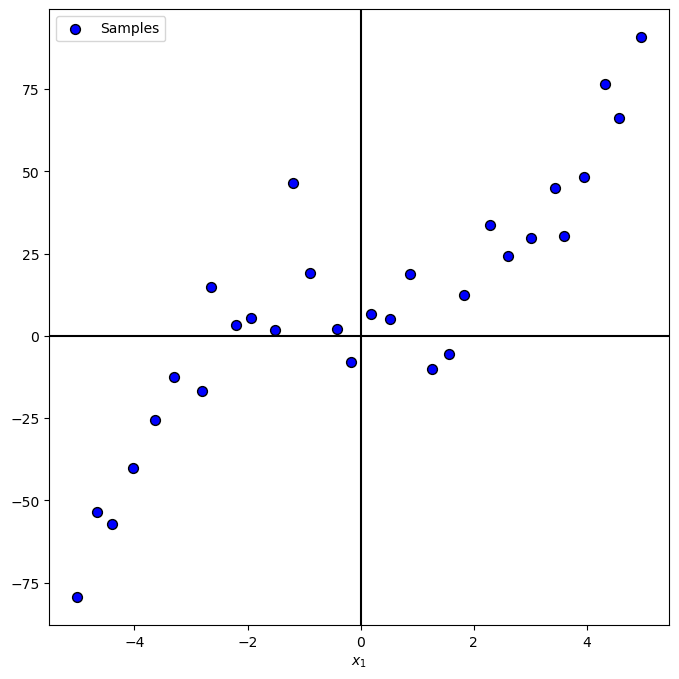

In [11]:
# Plot the Data

PlotRegressionData(vX, vY)

plt.show()


## Train Test Split

In order to show the importance of the regularization, we'll apply a split on the data.

In [12]:
# Train Test Split

mX = np.reshape(vX, (-1, 1))
mXTrain, mXTest, vYTrain, vYTest = train_test_split(mX, vY, test_size = numSamplesTest, train_size = numSamplesTrain, shuffle = True)

* <font color='red'>(**?**)</font> What does `stratify` mean in the context of splitting data for regression? 

## Train a Regularized Polyfit Regressor

The regularized PolyFit optimization problem is given by:

$$ \arg \min_{\boldsymbol{w}} {\left\| \boldsymbol{X} \boldsymbol{w} - \boldsymbol{y} \right|}_{2}^{2} + \lambda R \left( \boldsymbol{w} \right) $$

Where

$$
\boldsymbol{X} = \begin{bmatrix} 1 & x_{1} & x_{1}^{2} & \cdots & x_{1}^{p} \\
1 & x_{2} & x_{2}^{2} & \cdots & x_{2}^{p} \\
\vdots & \vdots & \vdots &  & \vdots \\
1 & x_{N} & x_{N}^{2} & \cdots & x_{N}^{p}
\end{bmatrix}
$$

And $R \left( \boldsymbol{w} \right)$ is the regularization function.


In [13]:
# Pipelines

# We could use the same instance of polynomial features object for both
pPolyFitL1 = Pipeline([('PolyFeatures', PolynomialFeatures(include_bias = False)), ('Regressor', Lasso(fit_intercept = True, max_iter = maximumIter))])
pPolyFitL2 = Pipeline([('PolyFeatures', PolynomialFeatures(include_bias = False)), ('Regressor', Ridge(fit_intercept = True))])


*** in optuna (optimal tuning of hyper parameters) *** we might do one pipeline with 2 regressors, one with L1 and one with L2 regularization.
 ????

In [14]:
# Score Data Frame

numComb = len(lPolyDeg) * len(lλ)
dData   = {'Poly Degree': [], 'λ': [], 'Train R2 L1 Regularization': [0.0] * numComb, 'Test R2 L1 Regularization': [0.0] * numComb, 'Train R2 L2 Regularization': [0.0] * numComb, 'Test R2 L2 Regularization': [0.0] * numComb}

for ii, polyDeg in enumerate(lPolyDeg):
    for jj, paramλ in enumerate(lλ):
        dData['Poly Degree'].append(polyDeg)
        dData['λ'].append(paramλ)
#===============================================================#

dfModelScore = pd.DataFrame(data = dData)
dfModelScore

,Poly Degree,λ,Train R2 L1 Regularization,Test R2 L1 Regularization,Train R2 L2 Regularization,Test R2 L2 Regularization
0,3,0.2,0.0,0.0,0.0,0.0
1,3,0.4,0.0,0.0,0.0,0.0
2,3,0.6,0.0,0.0,0.0,0.0
3,3,0.8,0.0,0.0,0.0,0.0
4,3,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
3995,9,199.2,0.0,0.0,0.0,0.0
3996,9,199.4,0.0,0.0,0.0,0.0
3997,9,199.6,0.0,0.0,0.0,0.0
3998,9,199.8,0.0,0.0,0.0,0.0


In [15]:
# Scoring the Models

for ii in range(numComb):
    polyDeg  = dfModelScore.loc[ii, 'Poly Degree']
    paramλ   = dfModelScore.loc[ii, 'λ']

    print(f'Processing model {ii + 1:03d} out of {numComb} with `degree` = {polyDeg} and `λ` = {paramλ}.')

    # The `__` Trick for Pipelines
    pPolyFitL1.set_params(PolyFeatures__degree = polyDeg)
    pPolyFitL1.set_params(Regressor__alpha = paramλ)
    pPolyFitL2.set_params(PolyFeatures__degree = polyDeg)
    pPolyFitL2.set_params(Regressor__alpha = paramλ)

    pPolyFitL1.fit(mXTrain, vYTrain)
    pPolyFitL2.fit(mXTrain, vYTrain)

    dfModelScore.loc[ii, 'Train R2 L1 Regularization'] = pPolyFitL1.score(mXTrain, vYTrain)
    dfModelScore.loc[ii, 'Test R2 L1 Regularization'] = pPolyFitL1.score(mXTest, vYTest)
    dfModelScore.loc[ii, 'Train R2 L2 Regularization'] = pPolyFitL2.score(mXTrain, vYTrain)
    dfModelScore.loc[ii, 'Test R2 L2 Regularization'] = pPolyFitL2.score(mXTest, vYTest)

Processing model 001 out of 4000 with `degree` = 3 and `λ` = 0.2.
Processing model 002 out of 4000 with `degree` = 3 and `λ` = 0.4.
Processing model 003 out of 4000 with `degree` = 3 and `λ` = 0.6000000000000001.
Processing model 004 out of 4000 with `degree` = 3 and `λ` = 0.8.
Processing model 005 out of 4000 with `degree` = 3 and `λ` = 1.0.
Processing model 006 out of 4000 with `degree` = 3 and `λ` = 1.2000000000000002.
Processing model 007 out of 4000 with `degree` = 3 and `λ` = 1.4000000000000001.
Processing model 008 out of 4000 with `degree` = 3 and `λ` = 1.6.
Processing model 009 out of 4000 with `degree` = 3 and `λ` = 1.8.
Processing model 010 out of 4000 with `degree` = 3 and `λ` = 2.0.
Processing model 011 out of 4000 with `degree` = 3 and `λ` = 2.2.
Processing model 012 out of 4000 with `degree` = 3 and `λ` = 2.4000000000000004.
Processing model 013 out of 4000 with `degree` = 3 and `λ` = 2.6.
Processing model 014 out of 4000 with `degree` = 3 and `λ` = 2.8000000000000003.
P

/data/solai/venvMamabaFixel/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.814e+02, tolerance: 2.808e+00
  model = cd_fast.enet_coordinate_descent(


Processing model 3002 out of 4000 with `degree` = 9 and `λ` = 0.4.


/data/solai/venvMamabaFixel/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.301e+02, tolerance: 2.808e+00
  model = cd_fast.enet_coordinate_descent(


Processing model 3003 out of 4000 with `degree` = 9 and `λ` = 0.6000000000000001.


/data/solai/venvMamabaFixel/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.941e+01, tolerance: 2.808e+00
  model = cd_fast.enet_coordinate_descent(


Processing model 3004 out of 4000 with `degree` = 9 and `λ` = 0.8.
Processing model 3005 out of 4000 with `degree` = 9 and `λ` = 1.0.
Processing model 3006 out of 4000 with `degree` = 9 and `λ` = 1.2000000000000002.
Processing model 3007 out of 4000 with `degree` = 9 and `λ` = 1.4000000000000001.
Processing model 3008 out of 4000 with `degree` = 9 and `λ` = 1.6.
Processing model 3009 out of 4000 with `degree` = 9 and `λ` = 1.8.
Processing model 3010 out of 4000 with `degree` = 9 and `λ` = 2.0.
Processing model 3011 out of 4000 with `degree` = 9 and `λ` = 2.2.
Processing model 3012 out of 4000 with `degree` = 9 and `λ` = 2.4000000000000004.
Processing model 3013 out of 4000 with `degree` = 9 and `λ` = 2.6.
Processing model 3014 out of 4000 with `degree` = 9 and `λ` = 2.8000000000000003.
Processing model 3015 out of 4000 with `degree` = 9 and `λ` = 3.0.
Processing model 3016 out of 4000 with `degree` = 9 and `λ` = 3.2.
Processing model 3017 out of 4000 with `degree` = 9 and `λ` = 3.40000

In [16]:
# The Score DF

dfModelScore

,Poly Degree,λ,Train R2 L1 Regularization,Test R2 L1 Regularization,Train R2 L2 Regularization,Test R2 L2 Regularization
0,3,0.2,0.923892,0.850470,0.923917,0.851406
1,3,0.4,0.923814,0.849412,0.923917,0.851360
2,3,0.6,0.923685,0.848276,0.923917,0.851315
3,3,0.8,0.923504,0.847061,0.923917,0.851271
4,3,1.0,0.923330,0.846127,0.923916,0.851228
...,...,...,...,...,...,...
3995,9,199.2,0.910591,0.736066,0.938832,0.648940
3996,9,199.4,0.910563,0.735842,0.938832,0.648985
3997,9,199.6,0.910535,0.735617,0.938831,0.649030
3998,9,199.8,0.910507,0.735392,0.938830,0.649075


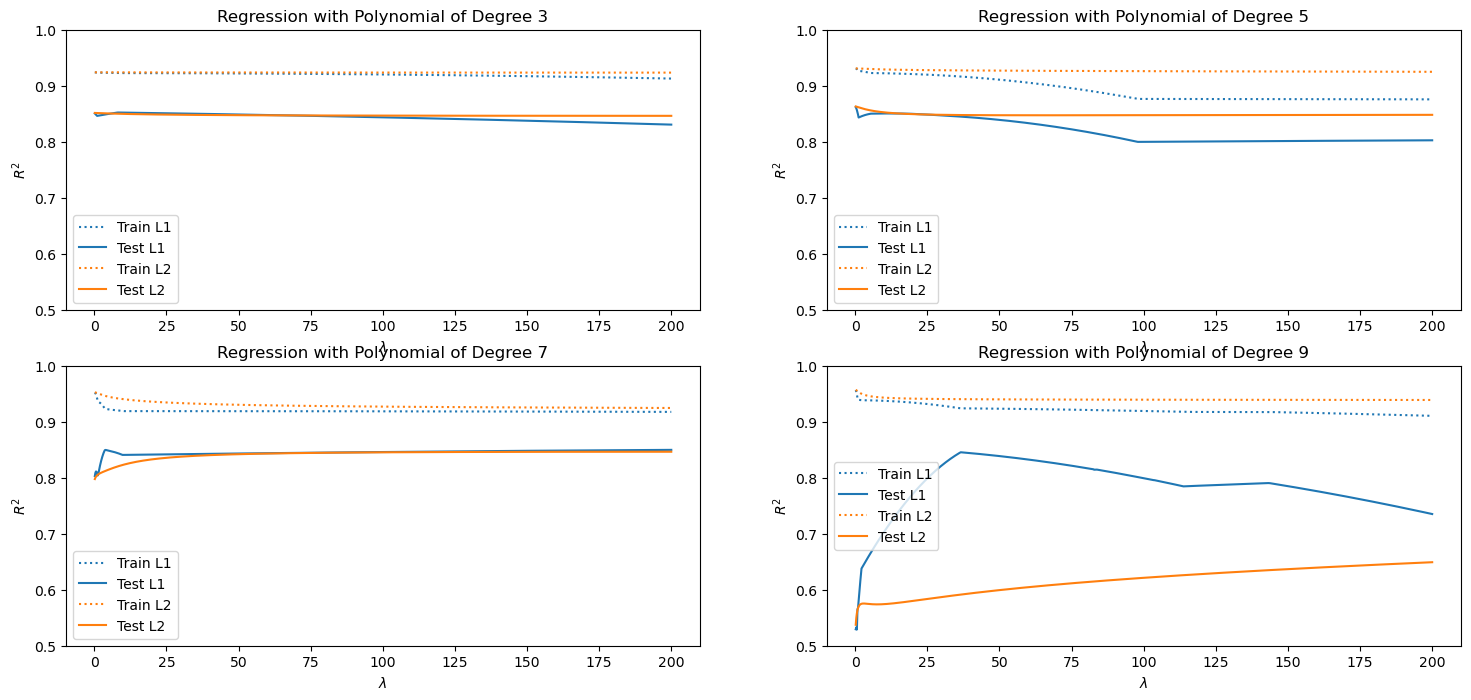

In [17]:
# Display Results

numFigures = len(lPolyDeg)
numRows    = 2
numCols    = int(np.ceil(numFigures / numRows))

hF, hA = plt.subplots(nrows = numRows, ncols = numCols, figsize = (18, 8))
hA = hA.flat

for ii, ax in enumerate(hA):
    if ii >= len(lPolyDeg):
        continue
    dsIdx = dfModelScore['Poly Degree'] == lPolyDeg[ii]
    ax.plot(lλ, dfModelScore.loc[dsIdx, 'Train R2 L1 Regularization'], color = 'C0', ls = ':', label = 'Train L1')
    ax.plot(lλ, dfModelScore.loc[dsIdx, 'Test R2 L1 Regularization'], color = 'C0', ls = '-', label = 'Test L1')
    ax.plot(lλ, dfModelScore.loc[dsIdx, 'Train R2 L2 Regularization'], color = 'C1', ls = ':', label = 'Train L2')
    ax.plot(lλ, dfModelScore.loc[dsIdx, 'Test R2 L2 Regularization'], color = 'C1', ls = '-', label = 'Test L2')

    ax.set_ylim((0.50, 1.00))

    ax.set_title(f'Regression with Polynomial of Degree {lPolyDeg[ii]}')
    ax.set_xlabel('$\lambda$')
    ax.set_ylabel('${R}^{2}$')

    ax.legend()